In [2]:
import shutil; print(shutil.which("latex"))

/Library/TeX/texbin/latex


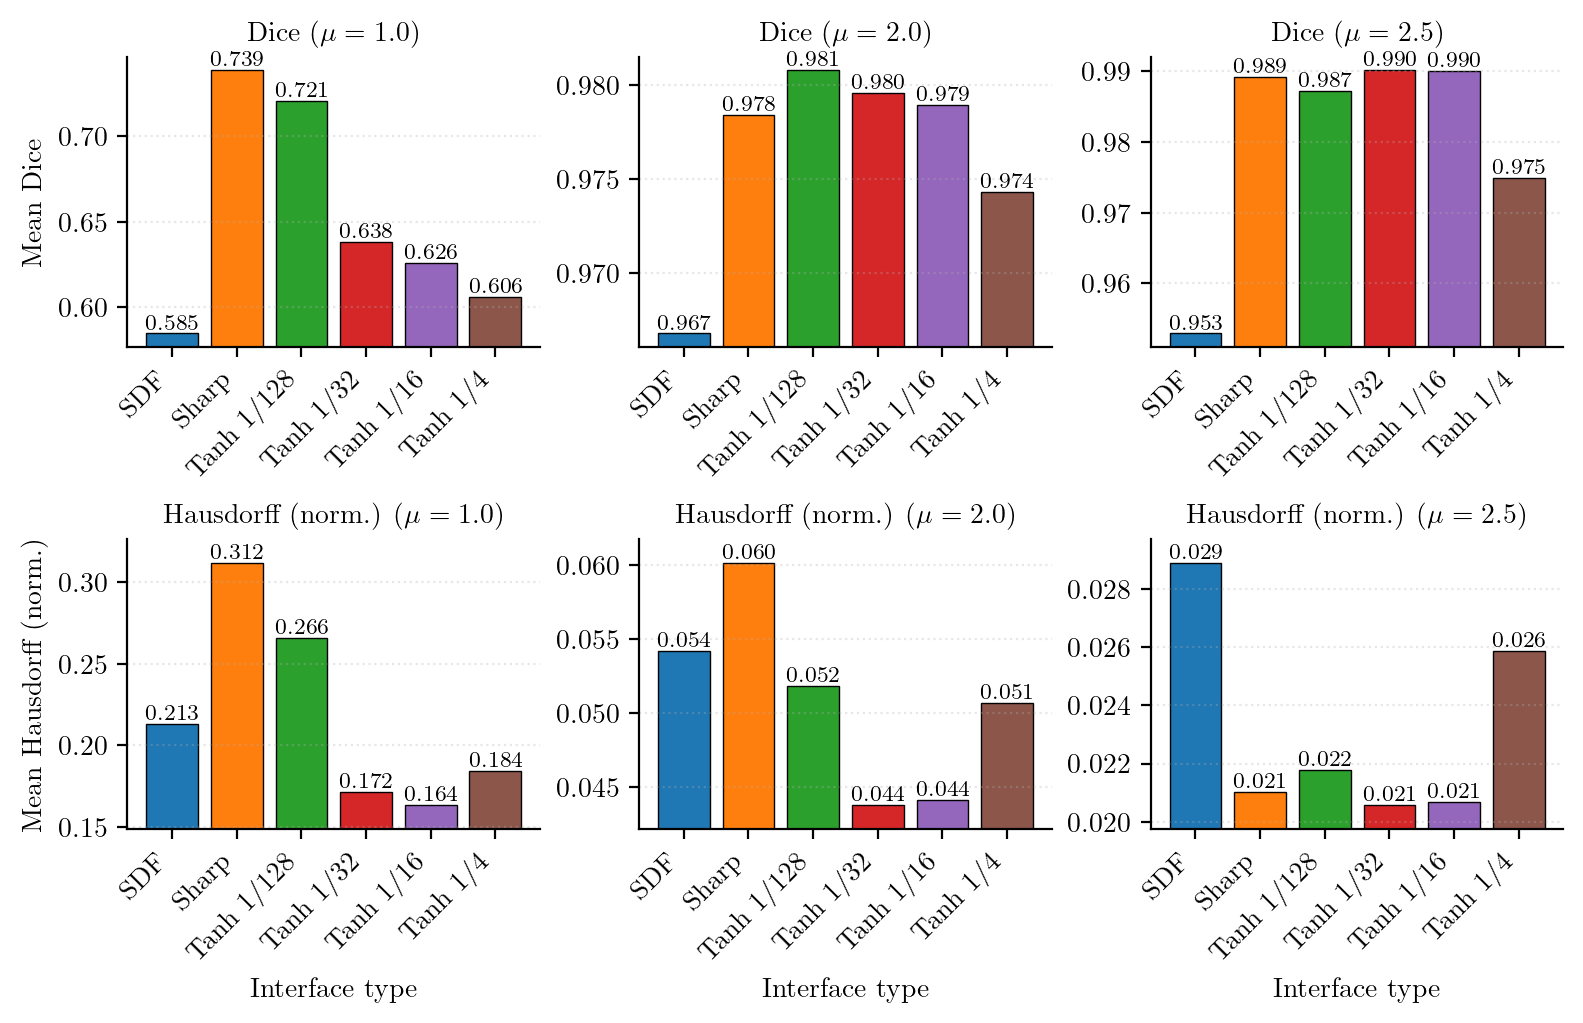

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

from src.interface_representation.interface_types import InterfaceType

# Use LaTeX for all text
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times'],
    'axes.unicode_minus': False
})

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

def label_from_row(row):
    interface_type = row['interface_type']
    epsilon = row['epsilon']
    if interface_type == InterfaceType.TANH_EPSILON.name:
        return f"Tanh {float_to_fraction(epsilon)}"
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT.name:
        return 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE.name:
        return 'SDF approx'
    elif interface_type == InterfaceType.HEAVISIDE.name:
        return 'Sharp'
    else:
        return 'Unknown'

def make_metric_table(df, value_column, drop_tanh_fractions=None, hausdorff_normalise=False):
    """
    Build a mu x label table of mean metric values.
    """
    if drop_tanh_fractions is None:
        drop_tanh_fractions = {'1/64', '1/8'}
    working = df.copy()
    working['label'] = working.apply(label_from_row, axis=1)

    if hausdorff_normalise:
        working[value_column] = working[value_column] / 64.0

    working = working[~working[value_column].isna()]
    table = working.groupby(['mu', 'label'])[value_column].mean().unstack()

    # Drop specific Tanh epsilon columns
    to_drop = []
    for col in table.columns:
        if isinstance(col, str) and col.startswith('Tanh'):
            frac = col.split()[-1]
            if frac in drop_tanh_fractions:
                to_drop.append(col)
    table = table.drop(columns=to_drop, errors='ignore')
    return table

def preferred_label_order(labels):
    """
    Order labels as: SDF, SDF approx, Sharp, then Tanh (ascending epsilon), then others.
    """
    labels = list(labels)
    ordered = []
    for core in ['SDF', 'SDF approx', 'Sharp']:
        if core in labels:
            ordered.append(core)
    # Tanh labels
    tanh_labels = [l for l in labels if isinstance(l, str) and l.startswith('Tanh') and l not in ordered]
    def tanh_key(lab):
        try:
            frac = lab.split()[-1]
            num, den = frac.split('/')
            return float(int(num) / int(den))
        except Exception:
            return float('inf')
    tanh_sorted = sorted(tanh_labels, key=tanh_key)
    ordered.extend(tanh_sorted)
    # Remaining others
    others = [l for l in labels if l not in ordered]
    ordered.extend(others)
    return ordered

def plot_bars_by_mu(
    df,
    mu_values=None,  # e.g., [0.1, 1.0, 10.0]; if None, uses up to first 3 sorted mus
    drop_tanh_fractions={'1/64', '1/8'},
    hausdorff_normalise=True,
    savepath='output/metrics_bars_by_mu.pdf',
    dpi=200
):
    """
    Create a grid of bar charts with columns = selected μ values and rows = metrics.
    Each subplot compares all interface types for a fixed μ.
    Metrics: Dice (top row) and Hausdorff normalized (bottom row, if hausdorff_normalise=True).
    """
    # Build tables
    dice_table = make_metric_table(df, 'dice', drop_tanh_fractions=drop_tanh_fractions, hausdorff_normalise=False)
    haus_table = make_metric_table(df, 'hausdorff', drop_tanh_fractions=drop_tanh_fractions, hausdorff_normalise=hausdorff_normalise)

    # Determine μs to plot (default up to 3 smallest μs available across both tables)
    all_mus = sorted(set(dice_table.index.tolist()) | set(haus_table.index.tolist()))
    if not all_mus:
        raise ValueError("No \\mu values found in the data after filtering.")
    if mu_values is None:
        mu_values = all_mus[:3]
    else:
        mu_values = [m for m in mu_values if m in all_mus]
        if len(mu_values) == 0:
            raise ValueError("None of the provided mu_values exist in the data.")

    # Determine and order labels consistently across both metrics
    all_labels = list(dict.fromkeys(list(dice_table.columns) + list(haus_table.columns)))
    labels = preferred_label_order(all_labels)

    # Color mapping for labels (consistent across subplots)
    cmap = plt.get_cmap('tab10')
    colors = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    n_cols = len(mu_values)
    fig, axs = plt.subplots(
        2, n_cols,
        figsize=(2.6 * n_cols, 5.0),
        sharey=False,  # Do not share y-axes
        constrained_layout=True,
        dpi=dpi
    )

    def _despine(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _plot_for_mu(ax, table, metric_name, mu_val, ylabel=None, is_dice=False):
        if mu_val not in table.index:
            ax.text(0.5, 0.5, r'No data', ha='center', va='center', fontsize=9, transform=ax.transAxes)
            ax.set_xticks([])
            if ylabel:
                ax.set_ylabel(ylabel)
            ax.set_title(rf"{metric_name} ($\mu={mu_val}$)", fontsize=10)
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            _despine(ax)
            return

        s = table.loc[mu_val, labels].dropna()
        labs = list(s.index)
        vals = s.values
        x = np.arange(len(labs))
        bar_colors = [colors[lab] for lab in labs]
        ax.bar(x, vals, color=bar_colors, edgecolor='black', linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels(labs, rotation=45, ha='right')
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.set_title(rf"{metric_name} ($\mu={mu_val}$)", fontsize=10)
        ax.grid(axis='y', linestyle=':', alpha=0.3)

        # Per-subplot y-limits (do not synchronize across plots)
        ymin, ymax = float(np.min(vals)), float(np.max(vals))
        if is_dice:
            ymin = max(0.0, ymin)
            ymax = min(1.0, ymax)
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
        else:
            pad = 0.1 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), ymax + pad)

        # Numeric labels above bars
        for xi, yi in zip(x, vals):
            ax.text(xi, yi, f"{yi:.3f}", ha='center', va='bottom', fontsize=8)

        # Despine
        _despine(ax)

    # Plot per μ (columns)
    for j, mu in enumerate(mu_values):
        # Dice row
        _plot_for_mu(
            axs[0, j], dice_table, "Dice", mu,
            ylabel="Mean Dice" if j == 0 else None,
            is_dice=True
        )
        # Hausdorff row
        haus_title = "Hausdorff (norm.)" if hausdorff_normalise else "Hausdorff"
        _plot_for_mu(
            axs[1, j], haus_table, haus_title, mu,
            ylabel=rf"Mean {haus_title}" if j == 0 else None,
            is_dice=False
        )
        # Only bottom row gets x-axis label for compactness
        axs[1, j].set_xlabel(r"Interface type")

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    return fig, axs

df = pd.read_csv('evaluation_results_v35.csv')
plot_bars_by_mu(df, savepath='metrics_bars_by_mu.pdf')
plt.show()

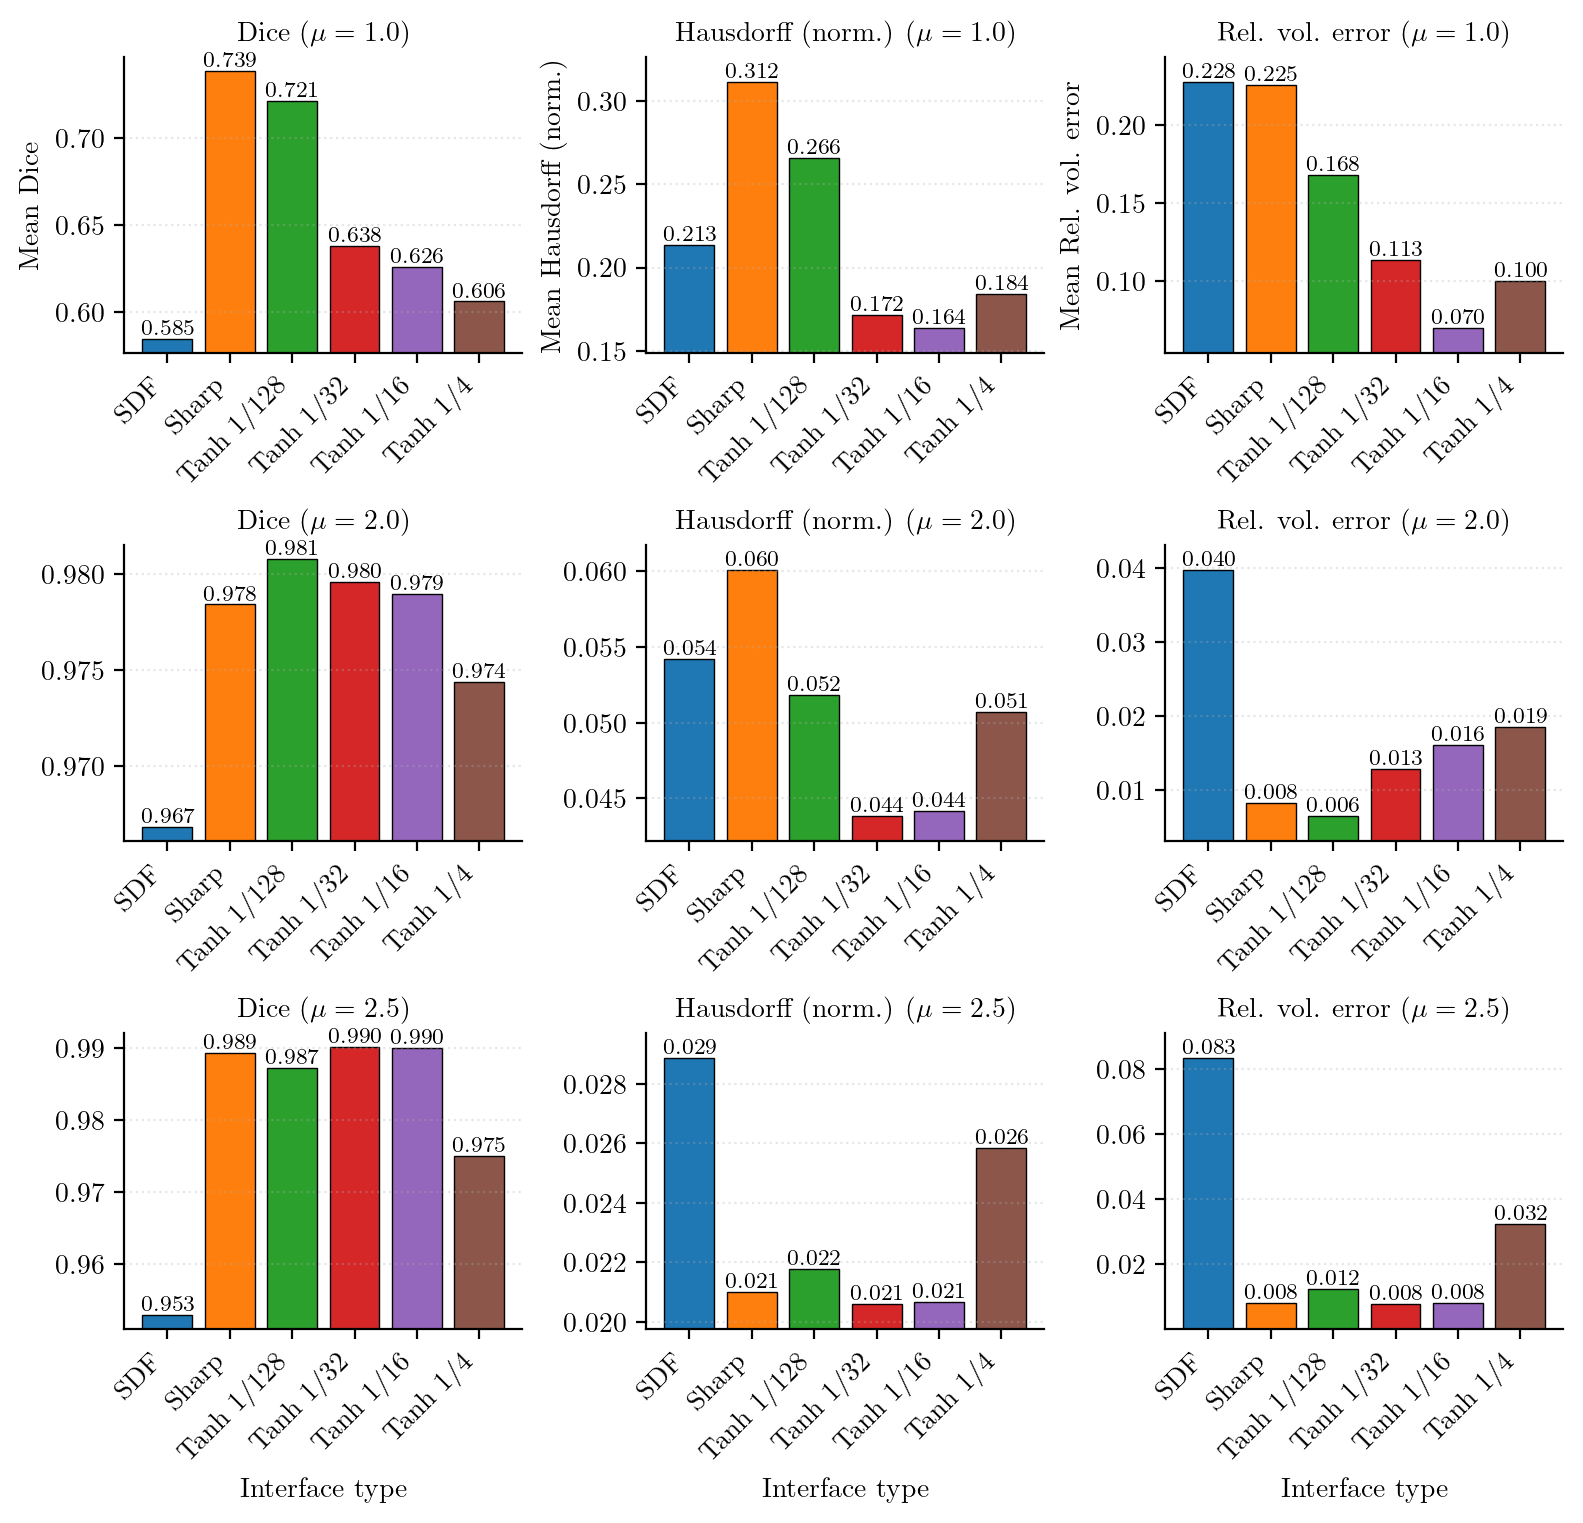

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

from src.interface_representation.interface_types import InterfaceType

# Use LaTeX for all text
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times'],
    'axes.unicode_minus': False
})

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

def label_from_row(row):
    interface_type = row['interface_type']
    epsilon = row['epsilon']
    if interface_type == InterfaceType.TANH_EPSILON.name:
        return f"Tanh {float_to_fraction(epsilon)}"
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT.name:
        return 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE.name:
        return 'SDF approx'
    elif interface_type == InterfaceType.HEAVISIDE.name:
        return 'Sharp'
    else:
        return 'Unknown'

def make_metric_table(df, value_column, drop_tanh_fractions=None, hausdorff_normalise=False):
    """
    Build a mu x label table of mean metric values.
    """
    if drop_tanh_fractions is None:
        drop_tanh_fractions = {'1/64', '1/8'}
    working = df.copy()
    working['label'] = working.apply(label_from_row, axis=1)

    if hausdorff_normalise and value_column == 'hausdorff':
        working[value_column] = working[value_column] / 64.0

    working = working[~working[value_column].isna()]
    table = working.groupby(['mu', 'label'])[value_column].mean().unstack()

    # Drop specific Tanh epsilon columns
    to_drop = []
    for col in table.columns:
        if isinstance(col, str) and col.startswith('Tanh'):
            frac = col.split()[-1]
            if frac in drop_tanh_fractions:
                to_drop.append(col)
    table = table.drop(columns=to_drop, errors='ignore')
    return table

def preferred_label_order(labels):
    """
    Order labels as: SDF, SDF approx, Sharp, then Tanh (ascending epsilon), then others.
    """
    labels = list(labels)
    ordered = []
    for core in ['SDF', 'SDF approx', 'Sharp']:
        if core in labels:
            ordered.append(core)
    # Tanh labels
    tanh_labels = [l for l in labels if isinstance(l, str) and l.startswith('Tanh') and l not in ordered]
    def tanh_key(lab):
        try:
            frac = lab.split()[-1]
            num, den = frac.split('/')
            return float(int(num) / int(den))
        except Exception:
            return float('inf')
    tanh_sorted = sorted(tanh_labels, key=tanh_key)
    ordered.extend(tanh_sorted)
    # Remaining others
    others = [l for l in labels if l not in ordered]
    ordered.extend(others)
    return ordered

def plot_bars_by_mu(
    df,
    mu_values=None,  # e.g., [0.1, 1.0, 10.0]; if None, uses up to first 3 sorted mus
    drop_tanh_fractions={'1/64', '1/8'},
    hausdorff_normalise=True,
    savepath='output/metrics_bars_by_mu.pdf',
    dpi=200
):
    """
    Create a grid of bar charts with rows = selected μ values and columns = metrics.
    Each subplot compares all interface types for a fixed μ.
    Metrics: Dice (first column), Hausdorff normalized (second column, if hausdorff_normalise=True),
             and Relative volume error (third column).
    """
    # Build tables
    dice_table = make_metric_table(df, 'dice', drop_tanh_fractions=drop_tanh_fractions, hausdorff_normalise=False)
    haus_table = make_metric_table(df, 'hausdorff', drop_tanh_fractions=drop_tanh_fractions, hausdorff_normalise=hausdorff_normalise)
    relvol_table = make_metric_table(df, 'rel_vol_error', drop_tanh_fractions=drop_tanh_fractions, hausdorff_normalise=False)

    # Determine μs to plot (default up to 3 smallest μs available across all tables)
    all_mus = sorted(set(dice_table.index.tolist()) | set(haus_table.index.tolist()) | set(relvol_table.index.tolist()))
    if not all_mus:
        raise ValueError("No \\mu values found in the data after filtering.")
    if mu_values is None:
        mu_values = all_mus[:3]
    else:
        mu_values = [m for m in mu_values if m in all_mus]
        if len(mu_values) == 0:
            raise ValueError("None of the provided mu_values exist in the data.")

    # Determine and order labels consistently across all metrics
    all_labels = list(dict.fromkeys(list(dice_table.columns) + list(haus_table.columns) + list(relvol_table.columns)))
    labels = preferred_label_order(all_labels)

    # Color mapping for labels (consistent across subplots)
    cmap = plt.get_cmap('tab10')
    colors = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    n_rows = len(mu_values)
    n_cols = 3
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(2.6 * n_cols, 2.5 * n_rows),
        sharey=False,  # Do not share y-axes
        constrained_layout=True,
        dpi=dpi,
        squeeze=False
    )

    def _despine(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _plot_for_mu(ax, table, metric_name, mu_val, ylabel=None, is_dice=False):
        if mu_val not in table.index:
            ax.text(0.5, 0.5, r'No data', ha='center', va='center', fontsize=9, transform=ax.transAxes)
            ax.set_xticks([])
            if ylabel:
                ax.set_ylabel(ylabel)
            ax.set_title(rf"{metric_name} ($\mu={mu_val}$)", fontsize=10)
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            _despine(ax)
            return

        s = table.loc[mu_val, labels].dropna()
        labs = list(s.index)
        vals = s.values
        x = np.arange(len(labs))
        bar_colors = [colors[lab] for lab in labs]
        ax.bar(x, vals, color=bar_colors, edgecolor='black', linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels(labs, rotation=45, ha='right')
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.set_title(rf"{metric_name} ($\mu={mu_val}$)", fontsize=10)
        ax.grid(axis='y', linestyle=':', alpha=0.3)

        # Per-subplot y-limits (do not synchronize across plots)
        ymin, ymax = float(np.min(vals)), float(np.max(vals))
        if is_dice:
            ymin = max(0.0, ymin)
            ymax = min(1.0, ymax)
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
        else:
            pad = 0.1 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), ymax + pad)

        # Numeric labels above bars
        for xi, yi in zip(x, vals):
            ax.text(xi, yi, f"{yi:.3f}", ha='center', va='bottom', fontsize=8)

        # Despine
        _despine(ax)

    # Plot per μ (rows)
    for i, mu in enumerate(mu_values):
        # Dice column
        _plot_for_mu(
            axs[i, 0], dice_table, "Dice", mu,
            ylabel="Mean Dice" if i == 0 else None,
            is_dice=True
        )
        # Hausdorff column
        haus_title = "Hausdorff (norm.)" if hausdorff_normalise else "Hausdorff"
        _plot_for_mu(
            axs[i, 1], haus_table, haus_title, mu,
            ylabel=rf"Mean {haus_title}" if i == 0 else None,
            is_dice=False
        )
        # Relative volume error column
        _plot_for_mu(
            axs[i, 2], relvol_table, "Rel. vol. error", mu,
            ylabel="Mean Rel. vol. error" if i == 0 else None,
            is_dice=False
        )

    # Only bottom row gets x-axis label for compactness
    for c in range(n_cols):
        axs[n_rows - 1, c].set_xlabel(r"Interface type")

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    return fig, axs

df = pd.read_csv('evaluation_results_v35.csv')
plot_bars_by_mu(df, savepath='metrics_bars_by_mu.pdf')
plt.show()